#**Credit Card Transactions Fraud Detection Dataset**

**IT461 Practical Machine Learning Project**


---


**By:**

*   Raseel Alrawdhan
*   Raghad Alharkan
*   Marya Asaad
*   Alia Alrassan
*   Sara alzayed


---



## **1-Introduction**

The objective of this project is to identify fake credit card transactions in a dataset with fabricated data from 1,000 clients and 800 vendors over a two-year period. It is crucial for financial institutions to have real-time fraud detection in order to minimize losses, protect customers, and maintain trust. By creating a reliable machine learning model that can accurately distinguish between valid and fraudulent transactions, financial institutions can reduce losses due to fraud, enhance the security of their services, and provide improved customer protection. This project aims to address the challenges associated with detecting fraud in large volumes of transactional data while minimizing false positives and maintaining efficient processing times.


## **2- Data dictionary**

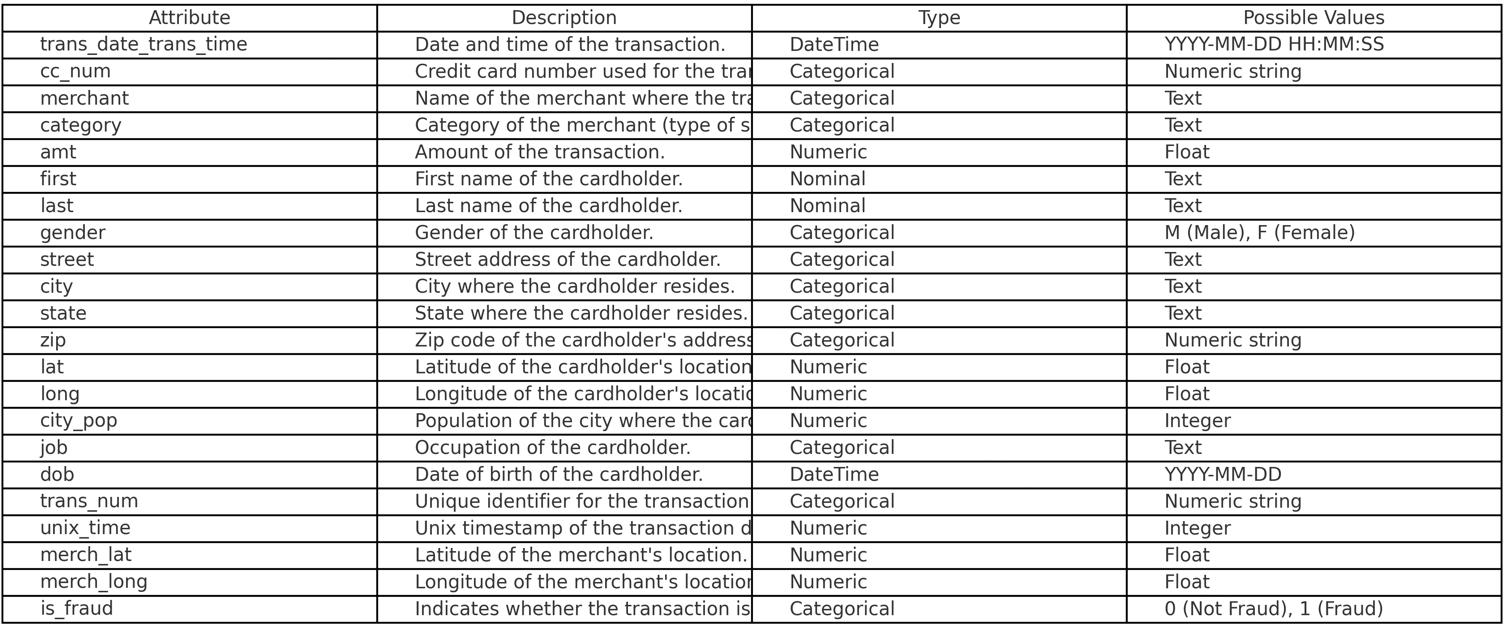

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score
import sklearn
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import scipy.stats as stats

In [ ]:
data = pd.read_csv("fraudDATA.csv")

In [ ]:
data.shape

(1296675, 23)

In [ ]:
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


# **2-Data Understanding:**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [ ]:
#its index column, so drop the "unnamed" column
data = data.drop(columns=['Unnamed: 0'])

In [ ]:
#number of fraud and not fraud
data["is_fraud"].value_counts()

,count
is_fraud,
0,1289169
1,7506




---


for visualization the data lets start with a pie plot for the catagory and the transaction relationship

Text(0.5, 1.0, 'Transactions by category')

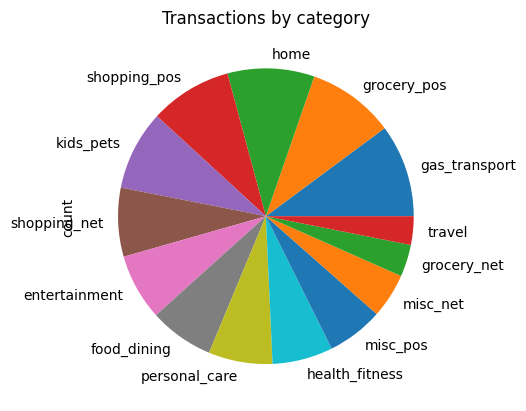

In [ ]:
data['category'].value_counts().plot.pie()
plt.title("Transactions by category")



---


Here we can see the analyzes of the total transaction amounts over time by aggregating daily totals from the dataset. It visualizes these amounts in a time series plot, helping to identify trends and patterns in spending behavior.

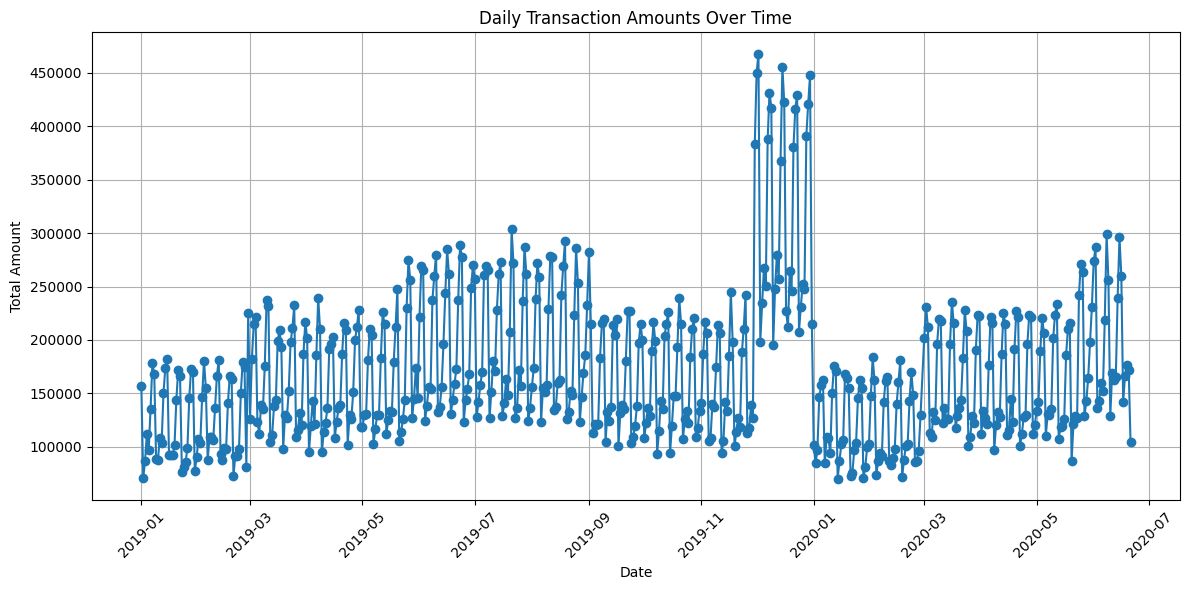

In [ ]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

# Extract the date from the datetime column
data['date'] = data['trans_date_trans_time'].dt.date

# Aggregate the transaction amounts by date
daily_transactions = data.groupby('date')['amt'].sum().reset_index()

# Plotting the time series of transaction amounts
plt.figure(figsize=(12, 6))
plt.plot(daily_transactions['date'], daily_transactions['amt'], marker='o')
plt.title('Daily Transaction Amounts Over Time')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()
plt.tight_layout()
plt.show()



---

This code calculates key statistics for the numeric columns
It includes basic descriptive statistics such as mean, minimum, maximum, and counts, along with additional metrics like mode, variance, and standard deviation.These statistics provide insights into the distribution and variability of the numeric features, which are essential for understanding the data before further analysis or modeling.

In [ ]:
# Calculate statistics for numeric features only
numeric_data = data.select_dtypes(include=[np.number])  # Filter for numeric columns

# Calculate basic statistics
stats = numeric_data.describe().T  # Basic statistics (mean, min, max, etc.)
stats['mode'] = numeric_data.mode().iloc[0]  # Add mode to the statistics
stats['variance'] = numeric_data.var()  # Add variance
stats['std_dev'] = numeric_data.std()  # Add standard deviation

# Display the statistics
print(stats)

                count          mean           std           min           25%  \
cc_num      1296675.0  4.171920e+17  1.308806e+18  6.041621e+10  1.800429e+14   
amt         1296675.0  7.035104e+01  1.603160e+02  1.000000e+00  9.650000e+00   
zip         1296675.0  4.880067e+04  2.689322e+04  1.257000e+03  2.623700e+04   
lat         1296675.0  3.853762e+01  5.075808e+00  2.002710e+01  3.462050e+01   
long        1296675.0 -9.022634e+01  1.375908e+01 -1.656723e+02 -9.679800e+01   
city_pop    1296675.0  8.882444e+04  3.019564e+05  2.300000e+01  7.430000e+02   
unix_time   1296675.0  1.349244e+09  1.284128e+07  1.325376e+09  1.338751e+09   
merch_lat   1296675.0  3.853734e+01  5.109788e+00  1.902779e+01  3.473357e+01   
merch_long  1296675.0 -9.022646e+01  1.377109e+01 -1.666712e+02 -9.689728e+01   
is_fraud    1296675.0  5.788652e-03  7.586269e-02  0.000000e+00  0.000000e+00   

                     50%           75%           max          mode  \
cc_num      3.521417e+15  4.642255e+15

# **2-Data Processing and Cleaning:**

In [ ]:
#drop the null values
data=data.dropna()
data.isnull().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


### **Encoding:**

for the features with a category type we will encode them as part of the preprocessing

In [ ]:
encoder = LabelEncoder()
data['category'] = encoder.fit_transform(data['category'])

# Create a DataFrame to display each category and its encoded value
categories = pd.DataFrame({
    'Original Category': encoder.inverse_transform(range(len(encoder.classes_))),
    'Encoded Value': range(len(encoder.classes_))
})

# Display the categories with their corresponding encoded values
print(categories)

   Original Category  Encoded Value
0      entertainment              0
1        food_dining              1
2      gas_transport              2
3        grocery_net              3
4        grocery_pos              4
5     health_fitness              5
6               home              6
7          kids_pets              7
8           misc_net              8
9           misc_pos              9
10     personal_care             10
11      shopping_net             11
12      shopping_pos             12
13            travel             13


In [ ]:
#lets do it for the state column
data['state'] = encoder.fit_transform(data['state'])
state = pd.DataFrame({
    'Original Category': encoder.inverse_transform(range(len(encoder.classes_))),
    'Encoded Value': range(len(encoder.classes_))
})

print(state)

   Original Category  Encoded Value
0                 AK              0
1                 AL              1
2                 AR              2
3                 AZ              3
4                 CA              4
5                 CO              5
6                 CT              6
7                 DC              7
8                 DE              8
9                 FL              9
10                GA             10
11                HI             11
12                IA             12
13                ID             13
14                IL             14
15                IN             15
16                KS             16
17                KY             17
18                LA             18
19                MA             19
20                MD             20
21                ME             21
22                MI             22
23                MN             23
24                MO             24
25                MS             25
26                MT        

In [ ]:
#lets do it for the gender column
data['gender'] = encoder.fit_transform(data['gender'])
gender = pd.DataFrame({
    'Original Category': encoder.inverse_transform(range(len(encoder.classes_))),
    'Encoded Value': range(len(encoder.classes_))
})

print(gender)

  Original Category  Encoded Value
0                 F              0
1                 M              1


### **Normlization :**

here we take the dob column calculate the age and add it as a column then we normalize it

In [ ]:
#Normlize
from datetime import datetime
# Convert 'dob' to datetime
data['dob'] = pd.to_datetime(data['dob'])

# Calculate age
current_date = datetime.now()
data['age'] = (current_date - data['dob']).dt.days // 365  # Age in years

# Normalize the age using Min-Max normalization
data['age_normalized'] = (data['age'] - data['age'].min()) / (data['age'].max() - data['age'].min())

### **the data after the encoding and normlization**

In [ ]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,age_normalized
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",8,4.97,Jennifer,Banks,0,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,36,0.209877
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",4,107.23,Stephanie,Gill,0,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,46,0.333333
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,0,220.11,Edward,Sanchez,1,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,62,0.530864
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",2,45.00,Jeremy,White,1,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,57,0.469136
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,9,41.96,Tyler,Garcia,1,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,38,0.234568


### **Handling the outliers:**

first lets count the outlier for each numeric column

In [ ]:
outlier_counts = {}

# Iterate over each numeric column to count outliers
for column in data.select_dtypes(include=[np.number]).columns:
    # Calculate IQR for the column
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outlier_count = data[(data[column] < lower_bound) | (data[column] > upper_bound)].shape[0]
    outlier_counts[column] = outlier_count

# Display the count of outliers for each numeric column
print("Number of outliers in each numeric column:")
for column, count in outlier_counts.items():
    print(f"{column}: {count} outliers")

Number of outliers in each numeric column:
cc_num: 118789 outliers
category: 0 outliers
amt: 67290 outliers
gender: 0 outliers
state: 0 outliers
zip: 0 outliers
lat: 4679 outliers
long: 49922 outliers
city_pop: 242674 outliers
unix_time: 0 outliers
merch_lat: 4967 outliers
merch_long: 41994 outliers
is_fraud: 7506 outliers
age: 536 outliers
age_normalized: 536 outliers


**some column here was expected to have these amounts of outliers, but we choose these 4 columns:**


**cc_num:** As a unique identifier, high outlier counts could reflect issues in data entry or fraudulent activity.


---


**amt:**The transaction amount is crucial for analysis; large outliers can skew the average and affect model performance.


---


**city_pop:**Population figures that are outliers could indicate inaccuracies in demographic data, which may impact the analysis of transaction behavior.


---


**lat and long:** Geographic coordinates with extreme values could suggest incorrect data points that may not represent actual locations, leading to misleading insights.

let's show the box plot of these columns:

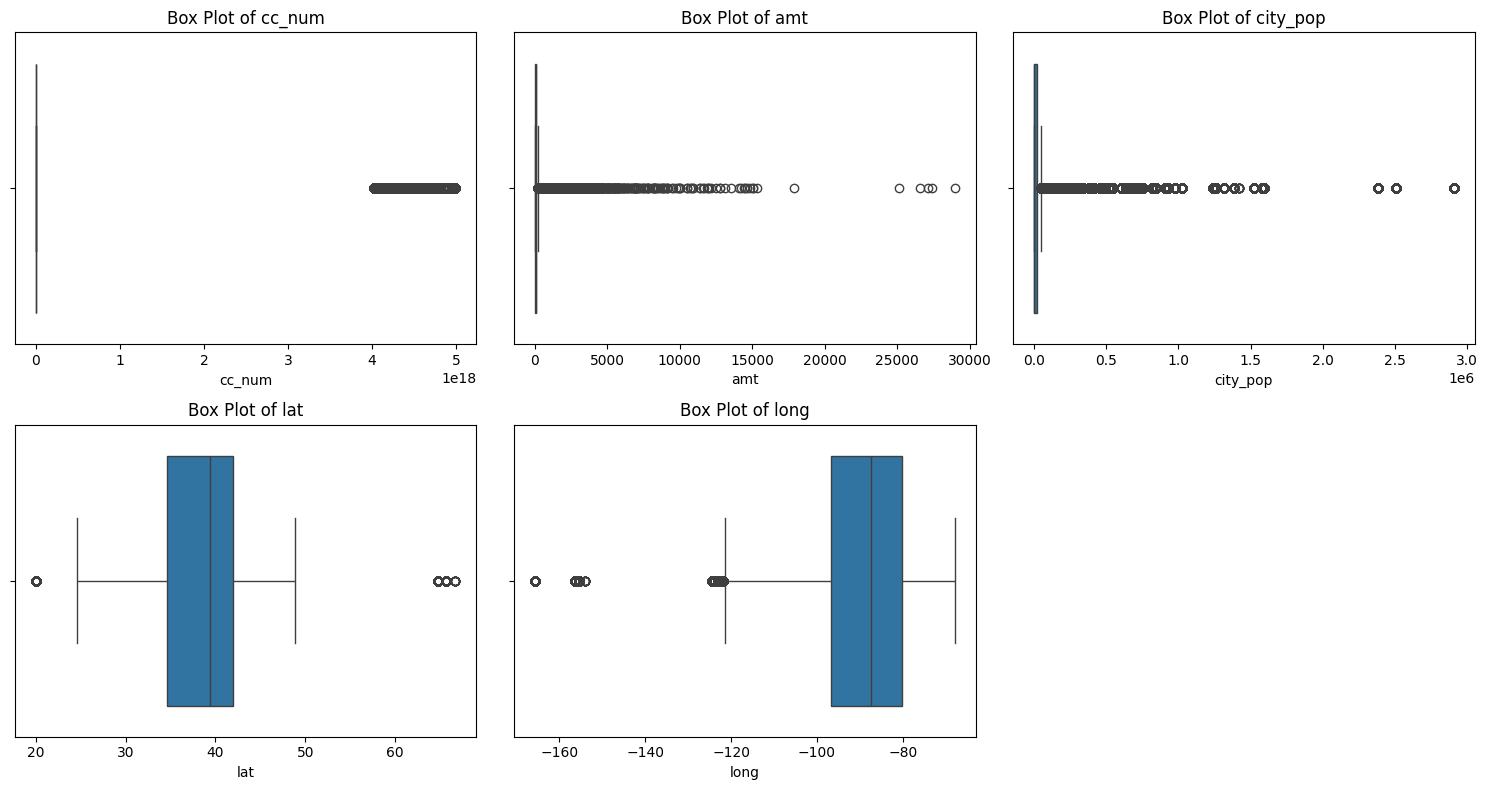

In [ ]:
# Create a figure for the box plots
plt.figure(figsize=(15, 8))

# List of columns to visualize
columns_to_plot = ['cc_num', 'amt', 'city_pop', 'lat', 'long']

# Iterate over each column to create box plots
for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 3, i + 1)  # Create a 2x3 grid for the subplots
    sns.boxplot(x=data[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

#### ***removing the outliers:***

In [ ]:
# List of columns to analyze for outliers
columns_to_clean = ['cc_num', 'amt', 'city_pop', 'lat', 'long']

# Remove outliers for each specified column
for column in columns_to_clean:
    # Calculate IQR for the column
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers from the DataFrame
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

## **Handel Imbalanced data:**

As you can see in the graph the dataset is unbalanced we will solve this using downsampling as the upsampling could affect us due to the number of records we have

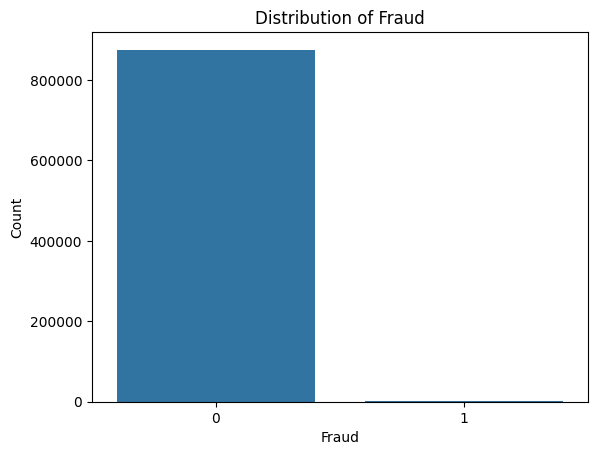

In [ ]:
fraud_counts=data['is_fraud'].value_counts()
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title('Distribution of Fraud')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.show()

In [ ]:
fraud=data[data["is_fraud"]==1]
not_fraud=data[data["is_fraud"]==0]
print(fraud.shape[0])
print(not_fraud.shape[0])

1317
1317


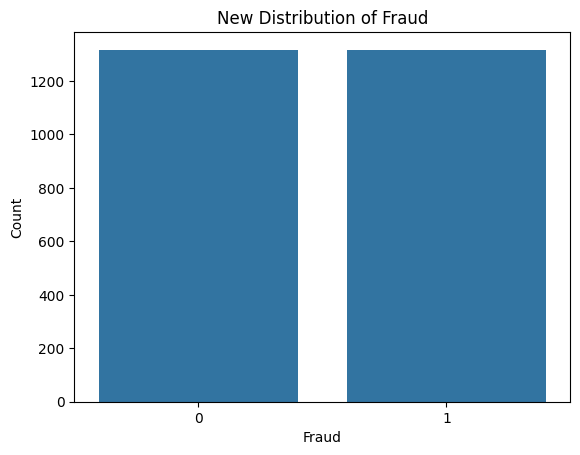

In [ ]:
not_fraud = not_fraud.sample(fraud.shape[0])
data = pd.concat([fraud, not_fraud])
fraud_counts=data['is_fraud'].value_counts()
sns.barplot(x=fraud_counts.index,y=fraud_counts.values)
plt.title('New Distribution of Fraud')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.show()

### **Feature selection:**

before the feature selection step we want to convert 'trans_date_trans_time' to datetime format and extract various time components that will help us to know the details about time

In [ ]:
data['trans_date_trans_time']=pd.to_datetime(data['trans_date_trans_time'])
data['trans_day']=data['trans_date_trans_time'].dt.day
data['trans_month']=data['trans_date_trans_time'].dt.month
data['trans_year']=data['trans_date_trans_time'].dt.year
data['trans_hour']=data['trans_date_trans_time'].dt.hour
data['trans_minute']=data['trans_date_trans_time'].dt.minute
data.drop(columns=['trans_date_trans_time'],inplace=True)

 To simplify our predictive model, we'll use a **feature selection technique** based on **variable importance derived from a Random Forest classifier.** This method allows us to identify and rank the significance of various input features in predicting our target variable, "is_fraud.", we did try the backward and forward feature selection but do the amount of data we could not manage these two methods

Ranked Features:
amt               0.300210
trans_hour        0.232649
category          0.138415
unix_time         0.034716
city_pop          0.027979
cc_num            0.024999
age               0.024928
age_normalized    0.023938
merch_lat         0.023278
zip               0.023043
merch_long        0.022515
lat               0.022002
long              0.020937
trans_day         0.020794
trans_minute      0.018754
state             0.016287
trans_month       0.016001
gender            0.006229
trans_year        0.002326
dtype: float64


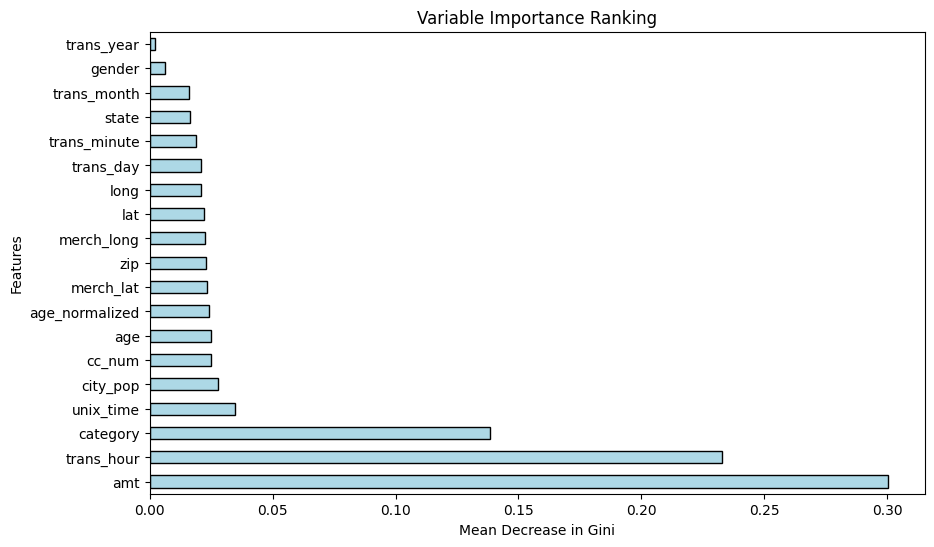

In [ ]:
# Convert the class label to a category
data['is_fraud'] = data['is_fraud'].astype('category')

# Separate the predictors and the class label
class_label = data['is_fraud']

# Filter for numeric columns only
numeric_predictors = data.select_dtypes(include=[np.number])  # This will include only numeric columns

class_label = class_label.cat.codes  # Convert categorical labels to integer codes

# Train a Random Forest model on numeric features only
model = RandomForestClassifier(random_state=7)
model.fit(numeric_predictors, class_label)

# Get the variable importance
importance = model.feature_importances_

# Create a Series for easier handling and sorting
importance_series = pd.Series(importance, index=numeric_predictors.columns)
ranked_features = importance_series.sort_values(ascending=False)

# Print the ranked features
print("Ranked Features:")
print(ranked_features)

# Plot the variable importance
plt.figure(figsize=(10, 6))
ranked_features.plot(kind='barh', color='lightblue', edgecolor='black')
plt.title("Variable Importance Ranking")
plt.xlabel("Mean Decrease in Gini")
plt.ylabel("Features")
plt.show()

after revirwing the ranking, we will be removing 'first', 'last', 'street','job', 'dob', 'city', 'state', 'trans_num', 'merchant', 'trans_year','trans_month', 'trans_minute', 'gender'

In [ ]:
unused_cols=['first','last','street','job','dob','city','state','trans_num','merchant', 'trans_year','trans_month', 'trans_minute','gender']
data.drop(columns=unused_cols,inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2634 entries, 2546 to 1108858
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   cc_num          2634 non-null   int64   
 1   category        2634 non-null   int64   
 2   amt             2634 non-null   float64 
 3   zip             2634 non-null   int64   
 4   lat             2634 non-null   float64 
 5   long            2634 non-null   float64 
 6   city_pop        2634 non-null   int64   
 7   unix_time       2634 non-null   int64   
 8   merch_lat       2634 non-null   float64 
 9   merch_long      2634 non-null   float64 
 10  is_fraud        2634 non-null   category
 11  age             2634 non-null   int64   
 12  age_normalized  2634 non-null   float64 
 13  trans_day       2634 non-null   int32   
 14  trans_hour      2634 non-null   int32   
dtypes: category(1), float64(6), int32(2), int64(6)
memory usage: 290.8 KB


# **3-ML Methods:**

### **1-Random forest:**

In [ ]:
X=data.drop('is_fraud',axis=1)
y=data['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
RFC=RandomForestClassifier(random_state=0)
RFC.fit(X_train,y_train)
y_pred=RFC.predict(X_test)
print('Accuracy:',accuracy_score(y_test, y_pred))
print('Precision:',precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Confusion matrix:',confusion_matrix(y_test, y_pred))

Accuracy: 0.9468690702087287
Precision: 0.9186046511627907
Recall: 0.9713114754098361
F1 score: 0.9442231075697212
Confusion matrix: [[262  21]
 [  7 237]]


### **2-Logistic Regression**

In [ ]:
from sklearn.model_selection import train_test_split
X=data.drop('is_fraud',axis=1)
y=data['is_fraud']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
lr=LogisticRegression()
lr.fit(x_train,y_train)
ŷ_train=lr.predict(x_train)
ŷ_test=lr.predict(x_test)
print("test_accuracy",accuracy_score(y_train,ŷ_train))
print("test_accuracy",accuracy_score(y_test,ŷ_test))
print("cross_validation",cross_val_score(lr,x_train,y_train,cv=5).mean())

test_accuracy 0.6929283341243474
test_accuracy 0.6850094876660342
cross_validation 0.6891310465940943


### **3-SVM with hyperparameter:**

here we determind the hyperparameters for svm model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

# Initialize the model
model = SVC()

# Define the hyperparameter grid
param_dist = {
    'svc__C': np.logspace(-3, 3, 20),
    'svc__gamma': np.logspace(-4, 2, 20),
    'svc__kernel': ['rbf', 'linear', 'sigmoid']  # Kernel types
}

In [ ]:
# Create a pipeline with scaling and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step to scale features
    ('svc', SVC())
])
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=8,       # Number of random combinations to try
    cv=3,            # Cross-validation folds
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1        # Use all available cores
)

# Fit the random search to find the best parameters
random_search.fit(X, y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc', SVC())]),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'svc__C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.274...
                                        'svc__gamma': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.35981829e-02, 6.95192796e-02, 1.43844989e-01, 2.97635144e-01,
       6.15848211e-01, 1.27427499e+00, 2.63665090e+00, 5.45559478e+00,
       1.12883789e+01, 2.33572147e+01, 4.83293024e+01, 1.00000000e+02]),
                                        'svc__kernel': ['rbf', 'linear',
                                                        'sigmoid']},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
# Output the best parameters and best score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Cross-validation on the best model
best_model = random_search.best_estimator_
cv_scores = cross_val_score(best_model, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Best Hyperparameters: {'svc__kernel': 'rbf', 'svc__gamma': 0.00379269019073225, 'svc__C': 483.2930238571752}
Best Cross-Validation Score: 0.6567957479119211
Cross-validation scores: [0.72296015 0.84819734 0.76660342 0.81783681 0.73193916]
Mean cross-validation score: 0.7775073772916501


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the best model on the training data
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)

# For a detailed report on each class
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8538899430740038
Precision: 0.8539011050340439
Recall: 0.8538899430740038
F1-Score: 0.8538678317488969

Confusion Matrix:
 [[218  40]
 [ 37 232]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85       258
           1       0.85      0.86      0.86       269

    accuracy                           0.85       527
   macro avg       0.85      0.85      0.85       527
weighted avg       0.85      0.85      0.85       527



A roc curve between the Random forest and SVM:

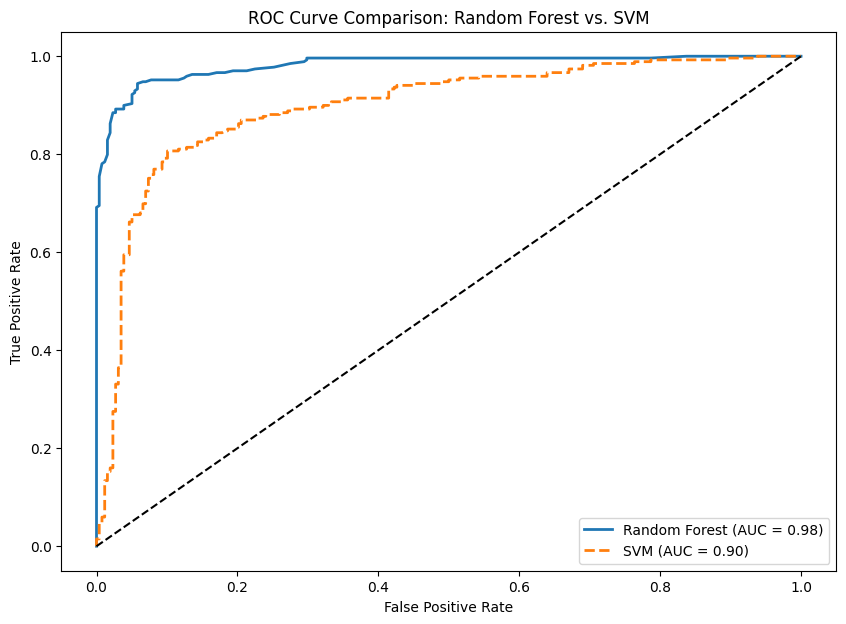

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the Random Forest model
random_forest_model = RandomForestClassifier(random_state=0)
random_forest_model.fit(X_train, y_train)

# Train the SVM model with hyperparameters
svm_model = SVC(probability=True, random_state=0)  # Set probability=True for predict_proba
svm_model.fit(X_train, y_train)

# Generate ROC Curve for Random Forest
y_prob_rf = random_forest_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

# Generate ROC Curve for SVM
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
auc_svm = roc_auc_score(y_test, y_prob_svm)

# Plot both ROC curves on the same graph
plt.figure(figsize=(10, 7))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', linestyle='-', linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})', linestyle='--', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')

# Plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Random Forest vs. SVM')
plt.legend(loc='lower right')
plt.show()


**The Random Forest model showed outstanding results, with an accuracy of around 94.5%, high precision (91.8%), recall (96.7%), and an F1 score of 94.2%. The confusion matrix shows that the model accurately classified most instances, with minimal false negatives and false positives.**

**On the other hand, the Logistic Regression model showed lower accuracy, 65.3% , indicating difficulties in accurately predicting the target compared to Random Forest.**

**The accuracy of the SVM model was approximately 85.6%, with equally balanced precision and recall rates of around 85.6%. Even though the SVM outperformed Logistic Regression, it did not reach the same level of accuracy and effectiveness as the Random Forest model. In this analysis, Random Forest performed better than both Logistic Regression and SVM, demonstrating its strength in managing the dataset.**

# **PHASE 2:**

in this phase, we aim to enhance the model's performance by optimizing the Random Forest algorithm, applying ensemble methods. These steps will help improve the model's accuracy and robustness in detecting fraudulent transactions.

## **1-RandomForest Classifier with hyperpamameter:**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

# Initialize the model
model = RandomForestClassifier(class_weight='balanced')

# Define the hyperparameter grid
param_dist = {
    'rf__n_estimators': [500, 600, 700, 800],  # number of trees
    'rf__max_features': ['auto', 'sqrt'],
    'rf__max_depth': [None, 50, 70, 100],  # Explore deeper trees
    'rf__min_samples_split': [1, 2],  # Allow for more splits
    'rf__min_samples_leaf': [1, 2],
    'rf__class_weight': ['balanced']  # Use balanced class weights
}

In [ ]:
# Create a pipeline with scaling and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,  # number of iterations
    cv=5,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search to find the best parameters
random_search.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
195 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/p

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'rf__class_weight': ['balanced'],
                                        'rf__max_depth': [None, 50, 70, 100],
                                        'rf__max_features': ['auto', 'sqrt'],
                                        'rf__min_samples_leaf': [1, 2],
                                        'rf__min_samples_split': [1, 2],
                                        'rf__n_estimators': [500, 600, 700,
                                                             800]},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:

# Output the best parameters and best score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Cross-validation on the best model
best_model = random_search.best_estimator_
cv_scores = cross_val_score(best_model, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Best Hyperparameters: {'rf__n_estimators': 700, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 100, 'rf__class_weight': 'balanced'}
Best Cross-Validation Score: 0.9673559353828616
Cross-validation scores: [0.93927894 0.97533207 0.96774194 0.9658444  0.97718631]
Mean cross-validation score: 0.9650767310481164


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the best model on the training data
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9772296015180265
Precision: 0.97748786411747
Recall: 0.9772296015180265
F1-Score: 0.9772320613744004

Confusion Matrix:
 [[260   9]
 [  3 255]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       269
           1       0.97      0.99      0.98       258

    accuracy                           0.98       527
   macro avg       0.98      0.98      0.98       527
weighted avg       0.98      0.98      0.98       527



## **2-Stacking Classifier Using Multiple Base Models (Random Forest, Gradient Boosting, XGBoost, LightGBM)**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ('lgbm', LGBMClassifier())
]

# Define the meta-model
meta_model = LogisticRegression()

# Create stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5  # Use 5-fold cross-validation
)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:

# Create a pipeline with scaling and stacking classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('stacking', stacking_clf)
])

# Set up parameter grid for GridSearchCV
param_grid = {
    'stacking__rf__n_estimators': [100, 200, 500],  # Random Forest
    'stacking__rf__max_depth': [None, 10, 20],
    'stacking__gb__n_estimators': [100, 200],       # Gradient Boosting
    'stacking__xgb__n_estimators': [100, 200],      # XGBoost
    'stacking__lgbm__n_estimators': [100, 200],     # LightGBM
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [ ]:

# Fit the grid search
grid_search.fit(X_train, y_train)

# Output the best parameters and best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:59:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1059, number of negative: 1048
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 2107, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502610 -> initscore=0.010441
[LightGBM] [Info] Start training from score 0.010441


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:59:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:59:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 847, number of negative: 838
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2509
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502671 -> initscore=0.010683
[LightGBM] [Info] Start training from score 0.010683
[LightGBM] [Info] Number of positive: 847, number of negative: 838
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502671 -> initscore=0.010683
[LightGBM] [Info] Start training from score 0.010683
[LightGBM] [Info] Number o

In [ ]:
# Predict on the test set with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and display metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the metrics
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9753320683111955

Confusion Matrix:
 [[262   7]
 [  6 252]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       269
           1       0.97      0.98      0.97       258

    accuracy                           0.98       527
   macro avg       0.98      0.98      0.98       527
weighted avg       0.98      0.98      0.98       527



ROC curve between the two new models:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:03:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1053, number of negative: 1054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2510
[LightGBM] [Info] Number of data points in the train set: 2107, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499763 -> initscore=-0.000949
[LightGBM] [Info] Start training from score -0.000949


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:03:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 842, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2514
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499703 -> initscore=-0.001187
[LightGBM] [Info] Start training from score -0.001187
[LightGBM] [Info] Number of positive: 842, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2509
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499703 -> initscore=-0.001187
[LightGBM] [Info] Start training from score -0.001187
[LightGBM] [Info] Numb

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:03:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1053, number of negative: 1054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2514
[LightGBM] [Info] Number of data points in the train set: 2107, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499763 -> initscore=-0.000949
[LightGBM] [Info] Start training from score -0.000949


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:04:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:04:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 842, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2514
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499703 -> initscore=-0.001187
[LightGBM] [Info] Start training from score -0.001187
[LightGBM] [Info] Number of positive: 842, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2509
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499703 -> initscore=-0.001187
[LightGBM] [Info] Start training from score -0.001187
[LightGBM] [Info] Numb

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:04:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1054, number of negative: 1053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2514
[LightGBM] [Info] Number of data points in the train set: 2107, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500237 -> initscore=0.000949
[LightGBM] [Info] Start training from score 0.000949


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:04:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 843, number of negative: 842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2517
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500297 -> initscore=0.001187
[LightGBM] [Info] Start training from score 0.001187
[LightGBM] [Info] Number of positive: 843, number of negative: 842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2507
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500297 -> initscore=0.001187
[LightGBM] [Inf

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:04:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1054, number of negative: 1053
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train set: 2107, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500237 -> initscore=0.000949
[LightGBM] [Info] Start training from score 0.000949


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:04:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:04:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 843, number of negative: 842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2514
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500297 -> initscore=0.001187
[LightGBM] [Info] Start training from score 0.001187
[LightGBM] [Info] Number of positive: 843, number of negative: 842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500297 -> initscore=0.001187
[LightGBM] [Info] Start training from score 0.001187
[LightGBM] [Info] Number o

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:04:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1054, number of negative: 1054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train set: 2108, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:04:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:04:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 843, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 1686, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 843, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 1686, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 843, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ove

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1053, number of negative: 1054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2490
[LightGBM] [Info] Number of data points in the train set: 2107, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499763 -> initscore=-0.000949
[LightGBM] [Info] Start training from score -0.000949


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 842, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2500
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499703 -> initscore=-0.001187
[LightGBM] [Info] Start training from score -0.001187
[LightGBM] [Info] Number of positive: 842, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2490
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499703 -> initscore=-0.001187
[LightGBM] [Info] Start training from score -0.001187
[LightGBM] [Info] Numb

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1053, number of negative: 1054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2496
[LightGBM] [Info] Number of data points in the train set: 2107, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499763 -> initscore=-0.000949
[LightGBM] [Info] Start training from score -0.000949


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 842, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2502
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499703 -> initscore=-0.001187
[LightGBM] [Info] Start training from score -0.001187
[LightGBM] [Info] Number of positive: 842, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2492
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499703 -> initscore=-0.001187
[LightGBM] [Info] Start training from score -0.001187
[LightGBM] [Info] Numb

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1054, number of negative: 1053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2501
[LightGBM] [Info] Number of data points in the train set: 2107, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500237 -> initscore=0.000949
[LightGBM] [Info] Start training from score 0.000949


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 843, number of negative: 842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2501
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500297 -> initscore=0.001187
[LightGBM] [Info] Start training from score 0.001187
[LightGBM] [Info] Number of positive: 843, number of negative: 842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2490
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500297 -> initscore=0.001187
[LightGBM] [Info] Start training from score 0.001187
[LightGBM] [Info] Number o

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1054, number of negative: 1053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2496
[LightGBM] [Info] Number of data points in the train set: 2107, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500237 -> initscore=0.000949
[LightGBM] [Info] Start training from score 0.000949


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 843, number of negative: 842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2502
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500297 -> initscore=0.001187
[LightGBM] [Info] Start training from score 0.001187
[LightGBM] [Info] Number of positive: 843, number of negative: 842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2500
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500297 -> initscore=0.001187
[LightGBM] [Info] Start training from score 0.001187
[LightGBM] [Info] Number o

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1054, number of negative: 1054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2499
[LightGBM] [Info] Number of data points in the train set: 2108, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 843, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2501
[LightGBM] [Info] Number of data points in the train set: 1686, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 843, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2495
[LightGBM] [Info] Number of data points in the train set: 1686, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 843, number of negative: 843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ove

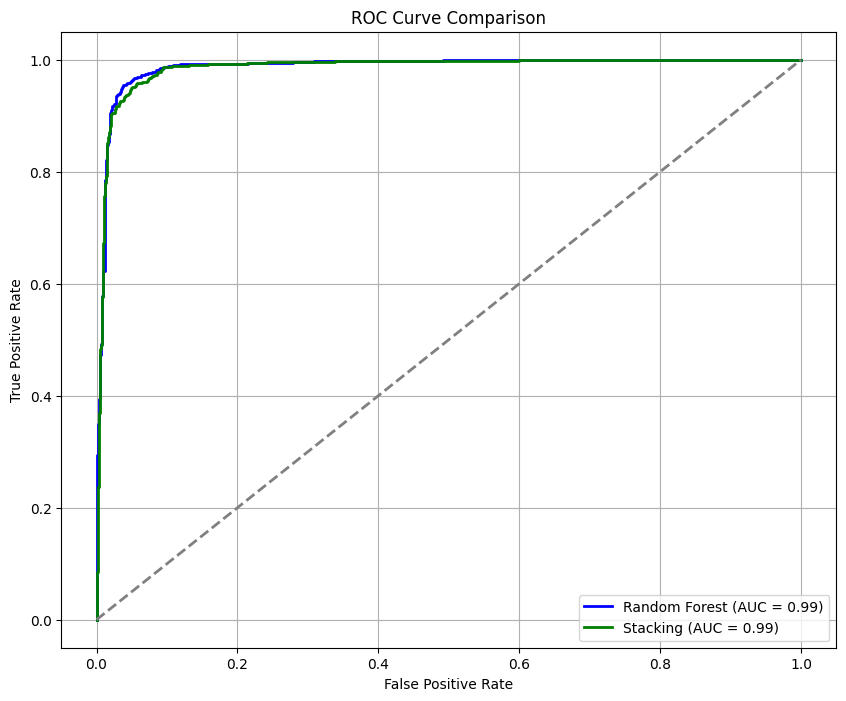

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
# Use cross-validation to generate predictions for ROC curve
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Get out-of-fold predicted probabilities
rf_probabilities_cv = cross_val_predict(random_forest_model, X, y, cv=cv, method='predict_proba')[:, 1]
stacking_probabilities_cv = cross_val_predict(stacking_model, X, y, cv=cv, method='predict_proba')[:, 1]

# Compute ROC curve for both models
fpr_rf, tpr_rf, _ = roc_curve(y, rf_probabilities_cv)
fpr_stacking, tpr_stacking, _ = roc_curve(y, stacking_probabilities_cv)

# Compute the AUC (Area Under Curve)
roc_auc_rf = roc_auc_score(y, rf_probabilities_cv)
roc_auc_stacking = roc_auc_score(y, stacking_probabilities_cv)

# Plot the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_stacking, tpr_stacking, color='green', lw=2, label=f'Stacking (AUC = {roc_auc_stacking:.2f})')

# Plot the diagonal line (chance level)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


**The Random Forest model using hyperparameter tuning showed excellent results with accuracy, precision, recall, and F1 score of 97.72%. The confusion matrix shows high predictive ability with few false negatives (3) and false positives (9), indicating that it is very dependable for detecting fraud.**


**The Stacking Classifier( Random Forest, Gradient Boosting, XGBoost, and LightGBM ), also showed strong performance with an accuracy of 97.53%, just below Random Forest. Even though the confusion matrix demonstrates a good balance with merely 6 false negatives and 7 false positives, it slightly fell short compared to Random Forest in terms of precision, recall, and F1 score, indicating it is effective but not better than Random Forest in this situation.**

# **LIVE TESTING THE MODELS**

Here the models are evaluated by predicting fraud on a small test dataset and comparing the results with predefined labels.

In [ ]:
import joblib
# Save the Random Forest (Phase 2) model
joblib.dump(best_model, 'random_forest_phase2.pkl')

# Save the Stacking Model
joblib.dump(stacking_clf, 'stacking_model.pkl')


In [ ]:
import pandas as pd

# Define the test dataset manually
small_test_data = pd.DataFrame({
    'cc_num': [345060451158891, 30442439074871, 30442439074871, 2305336922781618, 676372984911],
    'category': [13, 5, 7, 10, 7],
    'amt': [5.10, 19.65, 4.19, 174.38, 23.10],
    'zip': [1330, 18433, 18433, 52572, 66941],
    'lat': [42.5232, 41.5744, 41.5744, 40.6866, 39.7562],
    'long': [-72.8110, -75.5881, -75.5881, -92.6833, -98.4462],
    'city_pop': [1506, 6508, 6508, 1132, 242],
    'unix_time': [1350861165, 1336688136, 1333121075, 1349634759, 1370734644],
    'merch_lat': [41.794937, 41.028155, 41.432231, 41.571771, 40.611311],
    'merch_long': [-72.107355, -75.325967, -74.939611, -91.725218, -97.956204],
    'age': [64, 43, 43, 63, 37],
    'age_normalized': [0.555556, 0.296296, 0.296296, 0.543210, 0.222222],
    'trans_day': [21, 10, 30, 7, 8],
    'trans_hour': [23, 22, 15, 18, 23]
})

# Define the corresponding labels manually
small_test_labels = pd.Series([1, 1, 0, 0, 1], name='is_fraud')


In [ ]:
# Load the saved models
rf_phase2 = joblib.load('random_forest_phase2.pkl')
stacking_model = joblib.load('stacking_model.pkl')

# Make predictions
rf_phase2_preds = rf_phase2.predict(small_test_data)
stacking_preds = stacking_model.predict(small_test_data)

# Display results
print("Truth Labels:", list(small_test_labels))
print("\nRandom Forest Phase 2 Predictions:", list(rf_phase2_preds))
print("\nStacking Model Predictions:", list(stacking_preds))


Truth Labels: [1, 1, 0, 0, 1]

Random Forest Phase 2 Predictions: [1, 1, 0, 0, 1]

Stacking Model Predictions: [1, 1, 0, 0, 1]
